In [10]:
# Train torchvision with our dataset:
# https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html
# https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html

import copy
import json
import os
import time
import typing

import matplotlib.pyplot as plt
import numpy as np
import reload
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms

# Torch enable cuda
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print("=======================================================================")
print(" PyTorch version:     ", torch.__version__)
print(" Torchvision version: ", torchvision.__version__)
print(" Device:              ", device)
print("=======================================================================")


 PyTorch version:      1.13.0+cu117
 Torchvision version:  0.14.0+cu117
 Device:               cuda:0


In [11]:
%reload money_counter
from money_counter import data, models, validation_utils, constants
from torch.utils.data import Subset


In [12]:
DATASET_DIR = os.environ['COINS_DATASET_PATH']
MODEL_STATE_DIR = f'../model_state'

Load the model

In [13]:
# Load the model
model, model_name = models.get_fasterrcnn_v2_pretrained()

# Load the latest weights
version_manager = models.VersionManager(MODEL_STATE_DIR)

version_manager.load_model(model_name, model, mode="best")


(70, 3.248028741840936)

Load the data

In [14]:
_, data_loader_test = data.get_data_loaders(DATASET_DIR)


Draw the first 10 images with the boxes

In [15]:
image, target = next(iter(data_loader_test))

In [16]:
model.eval()
with torch.no_grad():
    predicted = model(image)
    


In [18]:
validation_utils.show_prediction(image[0], constants.CLASSES, target[0], predicted[0])


Error in callback <function _draw_all_if_interactive at 0x000001D92E7A1630> (for post_execute):


KeyboardInterrupt: 

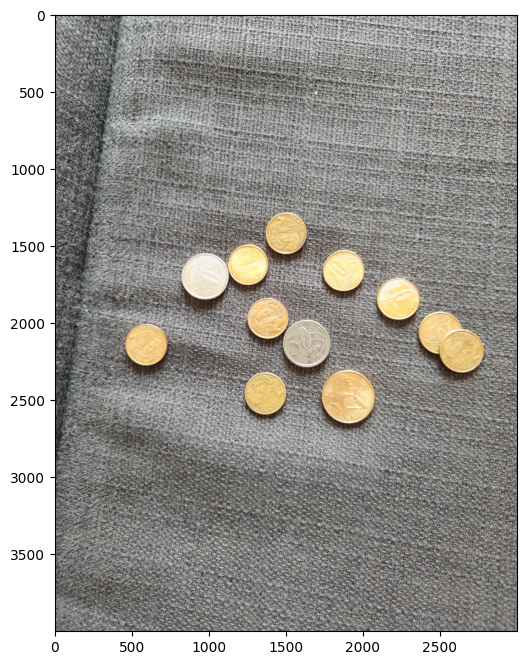

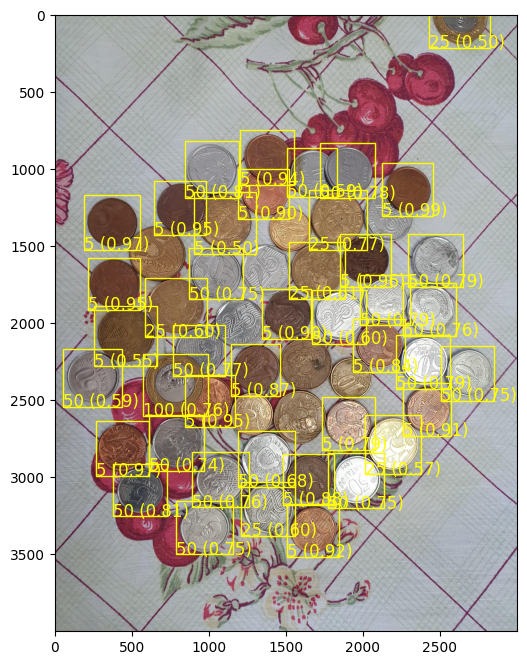

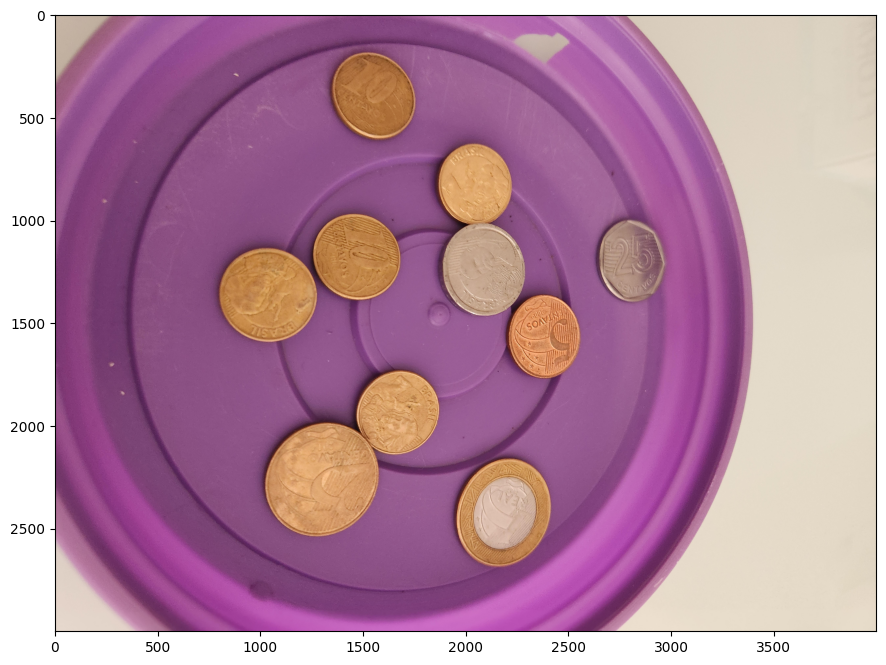

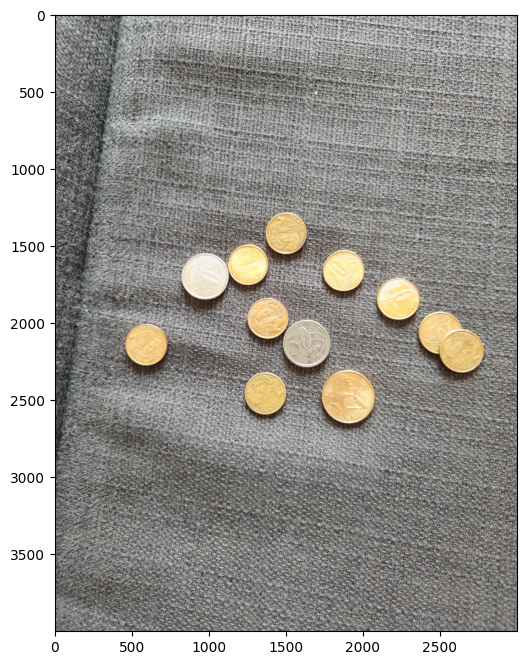

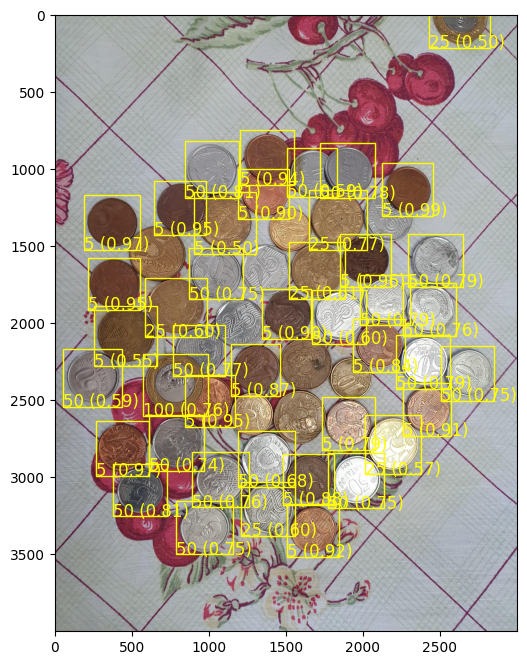

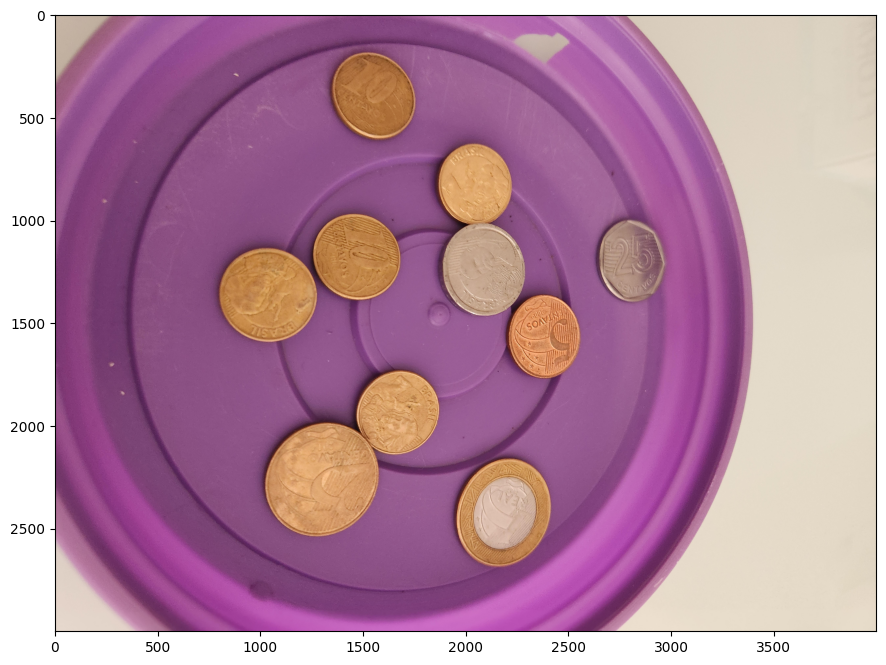

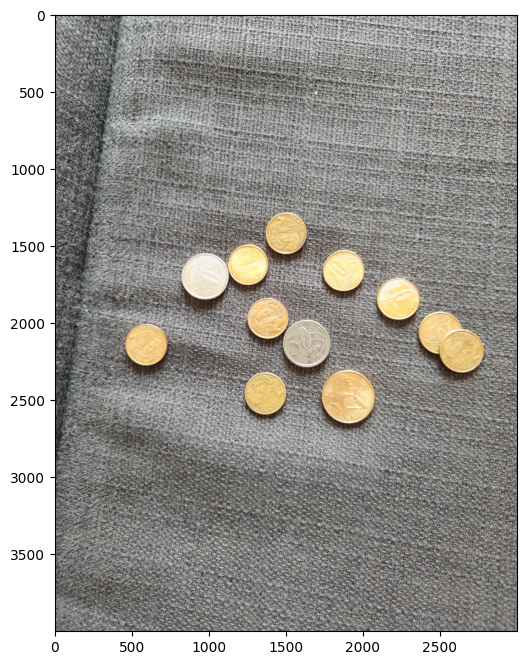

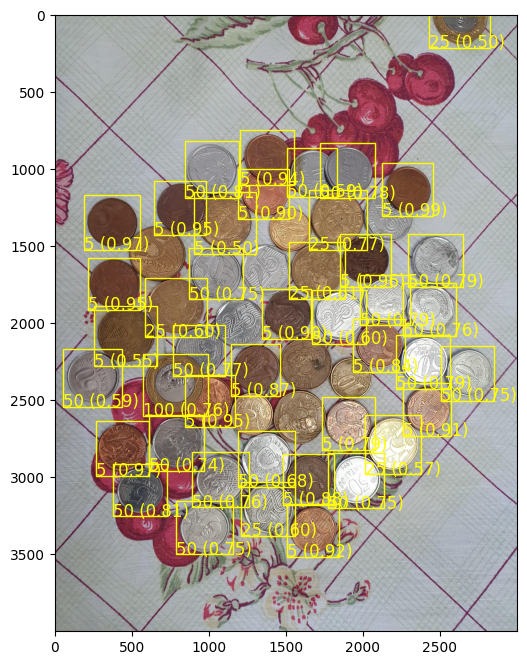

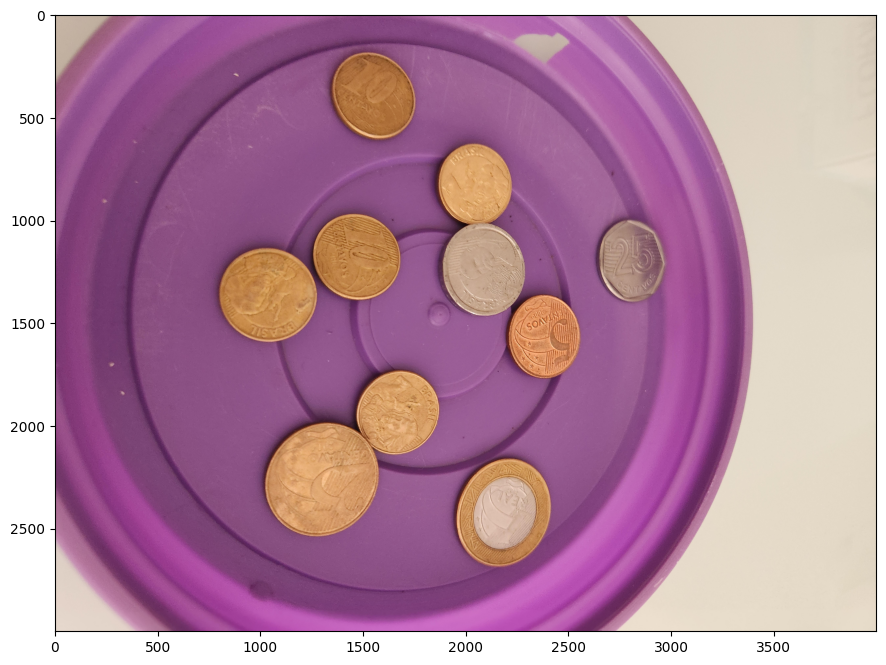

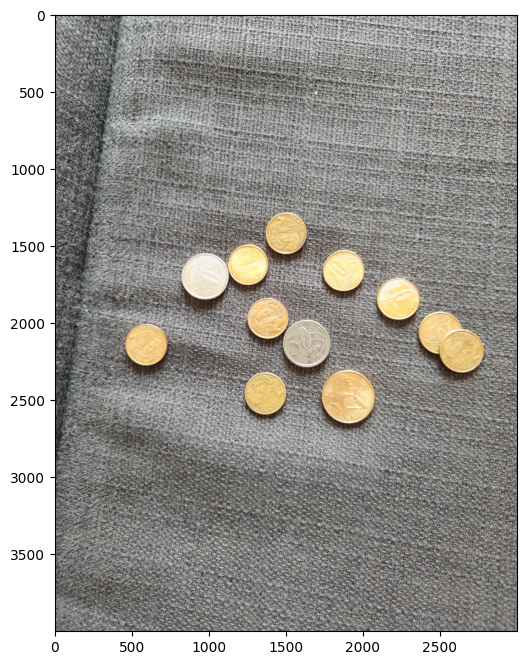

In [15]:
from typing import List
from money_counter.models import PredictedTarget
from money_counter.validation_utils import show_prediction
from money_counter import constants as const
from money_counter.engine import apply_nms

model = model.to(device)
model.eval()

label_map = {label: i for i, label in enumerate(const.CLASSES)}

with torch.no_grad():
    for _ in range(5):
        # Get some images from disk
        images, targets = next(iter(data_loader_test))
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Compute predictions
        predicted_targets = typing.cast(List[PredictedTarget], model(images))

        # apply nms
        apply_nms(predicted_targets, nms_threshold=0.5)

        # Render the image and the predictions
        for image, target, predicted in zip(images, targets, predicted_targets):
            # Move back to CPU
            image = image.cpu()
            target = {k: v.cpu() for k, v in target.items()}
            predicted = {k: v.cpu() for k, v in predicted.items()}

            subset_test = typing.cast(Subset, data_loader_test.dataset)
            data_set_test = typing.cast(data.ViaDataset, subset_test.dataset)

            inverted_label_map = {v: k for k, v in label_map.items()}

            show_prediction(
                image,  inverted_label_map, None, predicted, 0.5)
